In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'cornell\\CDS\pathways-vis'))
	print(os.getcwd())
except:
	pass


 # Recommending classes
 In this notebook, I'll be working toward a recommendation algorithm which can
 make useful class recommendations to students. This may take any of several
 different forms, described below:

 ## General Recommendations
 A good starting point, we may want to just accept one set of classes and find
 a set of classes which are also closely related or interesting.

 ## Point-to-Point
 We may see students define a set of classes they have taken, and a set of
 classes they would like to take. In this case, the algorithm would ideally
 provide a set of classes which either lie between those classes or would just
 also be generally interesting to that student.

 ## Exploratory
 This is much more challenging - we may want to recommend classes that the
 student has not yet demonstrated an interest in, but could potentially find
 intriguing. I don't know if we have the data to do this, but it would align
 closely with Pf. Kilczec's ideas.

In [1]:
import pandas as pd
import numpy as np
import test_extract
from test_extract import Data
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

FILENAME = "data/CIS_enrollment.csv"
ENCODING = "iso-8859-1"

data = Data(FILENAME)
raw  = pd.read_csv(FILENAME, encoding=ENCODING)


 ## Student-wise
 One easy way to make recommendations is to identify students who have taken
 the same or a similar set of courses and see what else they tend to take.

 ## Crosslisting
 We actually run into a fairly important problem here - crosslisting.
 Crosslisted courses, which are for our purposes the same, are distinct in the
 data model which greatly limits the accuracy of any model we build.

In [2]:
def translate(codes: List[str]) -> List[test_extract.Course]:
    """ Convert course codes into Course objects """
    courses = []
    for code in codes:
        courses.append(data.filterCourses(lambda c: c.id==code)[0])
    return courses

def show_results(df: pd.DataFrame):
    df['c'] = df.course.map(lambda code: 'C1' if code in beta else 'C0')
    df['size'] = df.course.map(lambda c: len(c.students))
    top = df.head(20)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    plt.subplots_adjust(wspace=0.4)

    ax1.scatter(df['size'], df.score, color=df.c)
    ax1.set_title("Overall Score Distribution")
    ax1.set_xlabel("Number of Students")
    ax1.set_ylabel("Score")


    ax2.barh(top.code, top.score, color=top.c)
    ax2.set_title("Class Recommendations")
    ax2.set_xlabel("Score")
    ax2.invert_yaxis()

    fig.show()
    return df.head(10)



In [3]:
def recommend_bystudent(courses: List[test_extract.Course]) -> pd.DataFrame:
    students = [course.students for course in courses]

    targets = set.intersection(*students)

    courses = data.getCourses()
    scores = map(lambda c: len(set.intersection(targets, c.students)), courses)

    recommendations = {
        'code': [course.id for course in courses],
        'course': courses,
        'score' : scores
    }

    return pd.DataFrame(recommendations).sort_values('score', ascending=False)


c:\Users\Sam\Documents\cornell\CDS\pathways-vis\env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,code,course,score,c,size
106,CS2800,"{'id': 'CS2800', 'name': 'Discrete Structures'...",274,C1,3073
83,CS1110,"{'id': 'CS1110', 'name': 'Intro Computing Usin...",274,C1,2325
301,CS2110,"{'id': 'CS2110', 'name': 'Obj-Oriented Prog & ...",274,C1,2235
779,CS2850,"{'id': 'CS2850', 'name': 'Networks', 'students...",274,C1,994
144,CS3110,"{'id': 'CS3110', 'name': 'Data Struct & Functi...",222,C0,2377
463,CS4820,"{'id': 'CS4820', 'name': 'Intro Analysis of Al...",194,C0,1951
440,CS3410,"{'id': 'CS3410', 'name': 'Systems Programming'...",184,C0,1919
12,MATH2940,"{'id': 'MATH2940', 'name': 'Linear Algebra for...",183,C0,2080
45,MATH1920,"{'id': 'MATH1920', 'name': 'Multivariable Calc...",179,C0,2163
188,CS4410,"{'id': 'CS4410', 'name': 'Operating Systems', ...",173,C0,1710


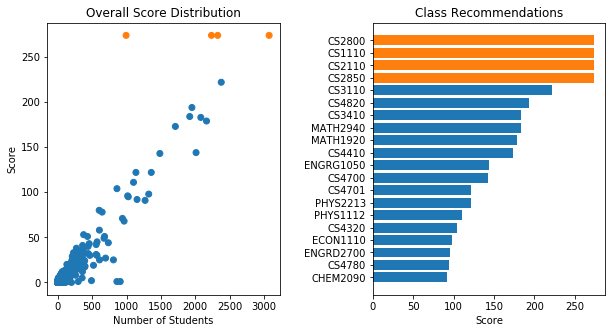

In [4]:
beta = translate(["CS2110", "CS2800", "CS2850", "CS1110"])

df = recommend_bystudent(beta)
show_results(df)


 Neat! This is actually pretty bad though. For one thing, we aren't
 accommodating for class sizes *at all*, so it's very heavily biased toward
 large classes. Note that it ranks ECON 1110, an almost completely unrelated
 course, above most relevant computer science electives. This is because Intro
 Microecon is just a massive class, so it's bound to have more of our target
 students in it than any smaller elective class. We can solve this. Instead of
 counting how many target students are in each class, let's count what
 proportion of the students who take each class are in our target population.

In [5]:
def recommend_bystudent_prop(courses: List[test_extract.Course], threshold=20) -> pd.DataFrame:
    students = [course.students for course in courses]

    targets = set.intersection(*students)

    def score(c: test_extract.Course) -> float:
        class_size = len(c.students)
        target_pop = len(set.intersection(targets, c.students))
        if class_size < threshold:
            return 0
        return target_pop / class_size

    courses = data.getCourses()
    scores = map(score, courses)

    recommendations = {
        'code': [course.id for course in courses],
        'course': courses,
        'score' : list(scores),
        'size': [len(course.students) for course in courses]
    }

    return pd.DataFrame(recommendations).sort_values('score', ascending=False)


 As usual, when using a ratio-based scoring method, we run into problems at the
 extreme low ends of the denominator (in this case, class size). We can see why
 in this chart.

c:\Users\Sam\Documents\cornell\CDS\pathways-vis\env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,code,course,score,size,c
779,CS2850,"{'id': 'CS2850', 'name': 'Networks', 'students...",0.275654,994,C1
1070,NBA6650,"{'id': 'NBA6650', 'name': 'Strat Mgmt of Tech ...",0.227273,22,C0
40,NBA6230,"{'id': 'NBA6230', 'name': 'Actualizing Your St...",0.222222,36,C0
429,NBA6330,"{'id': 'NBA6330', 'name': 'Actualizing Your St...",0.190476,21,C0
1082,BTRY4381,"{'id': 'BTRY4381', 'name': 'Bioinformatics Pro...",0.190476,42,C0
323,KOREA1101,"{'id': 'KOREA1101', 'name': 'Elementary Korean...",0.188679,53,C0
925,CS2770,"{'id': 'CS2770', 'name': 'Computational Sustai...",0.185185,27,C0
858,AEM3440,"{'id': 'AEM3440', 'name': 'Consumer Behavior',...",0.181818,33,C0
679,PE1346,"{'id': 'PE1346', 'name': 'Intermediate Boxing'...",0.181818,22,C0
935,ENGRC2640,"{'id': 'ENGRC2640', 'name': 'Tech Comm Applied...",0.180000,50,C0


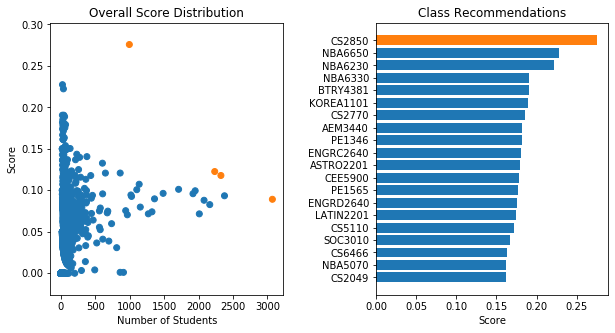

In [6]:
beta = translate(["CS2110", "CS2800", "CS2850", "CS1110"])

df = recommend_bystudent_prop(beta)
show_results(df)


 It should be pretty clear from the scatterplot above that we're skirting a
 critical problem. Let's demonstrate:

c:\Users\Sam\Documents\cornell\CDS\pathways-vis\env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,code,course,score,size,c
1082,BTRY4381,"{'id': 'BTRY4381', 'name': 'Bioinformatics Pro...",0.166667,42,C0
870,LATIN2201,"{'id': 'LATIN2201', 'name': 'Latin Prose', 'st...",0.130435,23,C0
522,CS4740,"{'id': 'CS4740', 'name': 'Intro to Natural Lan...",0.120743,646,C1
912,PE1565,"{'id': 'PE1565', 'name': 'Soccer', 'students':...",0.117647,34,C0
263,CS6670,"{'id': 'CS6670', 'name': 'Computer Vision', 's...",0.116279,43,C0
744,CS6466,"{'id': 'CS6466', 'name': 'Cryptocurrency and S...",0.102041,49,C0
247,AAS2130,"{'id': 'AAS2130', 'name': 'Intro To Asian Amer...",0.100000,20,C0
252,CS6740,"{'id': 'CS6740', 'name': 'Advanced Language Te...",0.100000,20,C0
963,NCC5500,"{'id': 'NCC5500', 'name': 'Financial Accountin...",0.095238,42,C0
1007,ENGRI1290,"{'id': 'ENGRI1290', 'name': 'Energy: Atoms to ...",0.095238,21,C0


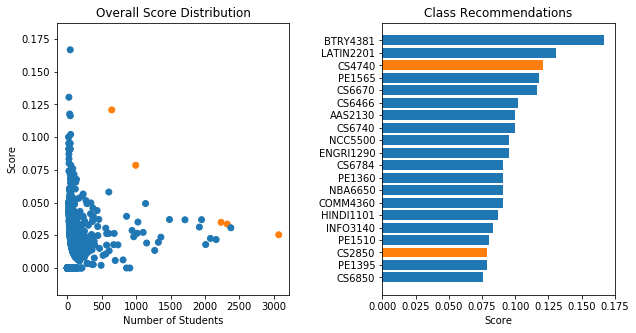

In [7]:
beta = translate(["CS2110", "CS2800", "CS2850", "CS1110", "CS4740"])

df = recommend_bystudent_prop(beta)
show_results(df)


 Obviously the model isn't actually very robust against adding classes. When we
 add a small class, the target population becomes so small that we tend to get
 scattered and random results. There's an argument to be made here that this
 could actually provide the kind of diversity of recommendation that Kilczec is
 looking for, but it doesn't seem to me that these recommendations are really
 that helpful for a given student. One way to improve might be to "soften" our
 target student pool - to include results from more students, but simply
 prioritize students who have taken classes in the input set.